In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import sys
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import math
import cv2
from PIL import Image

In [0]:
# function to read and decode tf record file

def read_and_decode(filename_queue):
  reader = tf.TFRecordReader()
  _, serialized_example = reader.read(filename_queue)
  features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'image_raw': tf.FixedLenFeature([], tf.string),
          'label': tf.FixedLenFeature([], tf.int64),
          'height': tf.FixedLenFeature([], tf.int64),
          'width': tf.FixedLenFeature([], tf.int64),
          'depth': tf.FixedLenFeature([], tf.int64)
      })
  image = tf.decode_raw(features['image_raw'], tf.uint8)
  label = tf.cast(features['label'], tf.int32)
  height = tf.cast(features['height'], tf.int32)
  width = tf.cast(features['width'], tf.int32)
  depth = tf.cast(features['depth'], tf.int32)
  return image, label, height, width, depth

In [3]:
# running the session to save the decoded tfrecord file into 'images' and 'labels' list
X_train = []
y_train = []

with tf.Session() as sess:
  filename_queue = tf.train.string_input_producer(["data.tfrecords"])
  image, label, height, width, depth = read_and_decode(filename_queue)
  image = tf.reshape(image, tf.stack([height, width, 3]))
  image.set_shape([100,100,3])
  init_op = tf.initialize_all_variables()
  sess.run(init_op)
  coord = tf.train.Coordinator()
  threads = tf.train.start_queue_runners(coord=coord)
  for i in range(149):
    example, l = sess.run([image, label])
    X_train.append(example)
    y_train.append(l)
  coord.request_stop()
  coord.join(threads)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecor

In [0]:
# running the session to save the decoded tfrecord file into 'images' and 'labels' list
X_test = []
y_test = []

with tf.Session() as sess:
  filename_queue = tf.train.string_input_producer(["test.tfrecords"])
  image, label, height, width, depth = read_and_decode(filename_queue)
  image = tf.reshape(image, tf.stack([height, width, 3]))
  image.set_shape([100,100,3])
  init_op = tf.initialize_all_variables()
  sess.run(init_op)
  coord = tf.train.Coordinator()
  threads = tf.train.start_queue_runners(coord=coord)
  for i in range(10):
    example, l = sess.run([image, label])
    X_test.append(example)
    y_test.append(l)
  coord.request_stop()
  coord.join(threads)

In [0]:
# converting images and labels list to numpy array

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

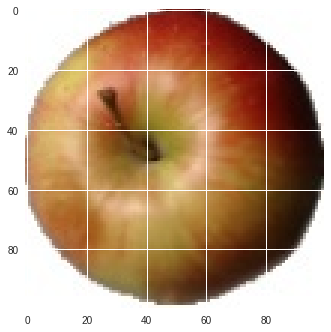

In [6]:
# checking the images decoded to confirm that dataset is proper and no dataloss has taken place

plt.imshow(X_test[8][:,:,[2,1,0]])

In [0]:
def get_data(X_train, y_train):
  
#     image normalization
    X_train = X_train/255
  
#     conversion of labels into one hot
#     this is used so that we can use softmax in the last layer of neural network
    y_one_hot = np.zeros((y_train.shape[0],2))
    for i in range(y_train.shape[0]):
        if(y_train[i] == 1):
            y_one_hot[i,1] = 1
        else:
            y_one_hot[i,0] = 1

    return (X_train,y_one_hot)

In [0]:
X_train, y_train = get_data(X_train,y_train)
X_test, y_test = get_data(X_test,y_test)

In [9]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(149, 100, 100, 3)
(149, 2)
(10, 100, 100, 3)
(10, 2)


In [0]:
def get_placeholders():
    X = tf.placeholder(tf.float32,shape=[None,X_train.shape[1],X_train.shape[2],X_train.shape[3]],name="X")
    y = tf.placeholder(tf.float32,shape=[None,y_train.shape[1]],name="y")
#     keep_prob = tf.placeholder(tf.float32)
    return X,y

In [0]:
def initialize_variables():
    parameters = {}
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1",[5,5,3,32],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[5,5,32,64],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    flatten = tf.get_variable("flatten",[5,5,64,1],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3",[625,32],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W4 = tf.get_variable("W4",[32,2],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    
    b1 = tf.Variable(tf.zeros([1,1,1,32]),name="b1")
    b2 = tf.Variable(tf.zeros([1,1,1,64]),name="b2")
    b_flatten=tf.Variable(tf.zeros([1,1,1,1]),name="b_flatten")
    b3 = tf.Variable(tf.zeros([32]),name="b3")
    b4 = tf.Variable(tf.zeros([2]),name="b4")
    
    parameters = {
        "W1":W1,
        "W2":W2,
        "W3":W3,
        "W4":W4,
        "b1":b1,
        "b2":b2,
        "b3":b3,
        "b4":b4,
        "flatten":flatten,
        "b_flatten":b_flatten,
        "keep_prob1": 0.5,
        "keep_prob2": 0.8,
        "keep_prob3": 0.8,
        "keep_prob4": 1.0
    }
    
    return parameters

In [0]:
def forward_pass(X_batch,parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    W4 = parameters["W4"]
    flatten=parameters["flatten"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    b3 = parameters["b3"]
    b4 = parameters["b4"]
    b_flatten=parameters["b_flatten"]
    keep_prob1 = parameters["keep_prob1"]
    keep_prob2 = parameters["keep_prob2"]
    keep_prob3 = parameters["keep_prob3"]
    keep_prob4 = parameters["keep_prob4"]
    
#     X_batch = X_batch.astype(np.float32)
    Z1 = tf.nn.conv2d(X_batch,W1,strides = [1,1,1,1],padding = 'SAME') + b1
    A1 = tf.nn.relu(Z1)
    A1= tf.nn.dropout(A1, keep_prob1)

    P1 = tf.nn.max_pool(A1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1,W2,strides = [1,1,1,1],padding = 'SAME') + b2
    A2 = tf.nn.relu(Z2)
    A2=tf.nn.dropout(A2, keep_prob2)

    P2 = tf.nn.max_pool(A2,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'SAME')
    
    P2_flat_ = tf.nn.conv2d(P2,flatten,strides = [1,1,1,1],padding='SAME')+b_flatten
    P2_flat = tf.nn.dropout((tf.nn.relu(P2_flat_)),keep_prob3)
    P2_flat = tf.layers.flatten(P2_flat)
    
    Z3= tf.matmul(P2_flat,W3) + b3
    A3 = tf.nn.relu(Z3)
    A3= tf.nn.dropout(A3, keep_prob4)
    
    Z4 = tf.matmul(A3,W4) + b4
    y_hat = tf.nn.sigmoid(Z4)
    
    return y_hat

In [0]:
def compute_cost(y_hat,y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_hat,labels=y))
    
    return cost

In [0]:
def check_accuracy(y_hat,y):
    
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_hat,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

In [0]:
def sample_minibatches(X,Y,batch_size = 100,seed = 0):
    np.random.seed(seed)
    
    shuffled_X = X 
    shuffled_Y = Y

    num_batches = (int)(X.shape[0]/(batch_size))
    minibatches = []
    
    for i in range(1,num_batches+1):
        minibatch_X = shuffled_X[(i-1)*batch_size:i*batch_size,:,:,:]
        minibatch_Y = shuffled_Y[(i-1)*batch_size:i*batch_size,:]
        minibatches.append((minibatch_X,minibatch_Y))
    
    if X.shape[0]%num_batches != 0:
        remainder = X.shape[0]%num_batches
        last_index = (int)(X.shape[0]/num_batches)
        
        minibatch_X = shuffled_X[last_index*num_batches:last_index*num_batches + remainder,:,:,:]
        minibatch_Y = shuffled_Y[last_index*num_batches:last_index*num_batches + remainder,:]
        
        minibatches.append((minibatch_X,minibatch_Y))
    
    return minibatches

In [0]:
def model(learning_rate,batch_size,num_epochs):

    with tf.device('/device:GPU:2'):
      batch_size= 15
      num_epochs= 200

      tf.reset_default_graph()
      ops.reset_default_graph()
      tf.set_random_seed(1)

      num_minibatches = math.ceil(X_train.shape[0]/batch_size)

  #     initializing variables
      X,y = get_placeholders()
      parameters = initialize_variables()

  #     forward pass
      y_hat = forward_pass(X,parameters)
      cost = compute_cost(y_hat,y)
      accuracy = check_accuracy(y_hat,y)

  #     optimizer definiton
      optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

      costs = []
      train_accuracy = []
      validation_accuracy = []
      validation_costs = []

      seed = 0

      start_time = time.time()

      best_val_loss = float("inf")
      patience = 0
      early_stopping = None

      feed_dict_validate={X:X_test,y:y_test}

#     defining session as sess and initializing variables
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            cost_temp = 0.0
            accuracy_train_temp = 0.0
            accuracy_validation_temp = 0.0
            val_cost_temp = 0.0

#             loading the training data in minibatches
            minibatches = sample_minibatches(X_train,y_train,batch_size=batch_size,seed=seed)

            seed = seed + 1
            count=0       

#             taking minibatch and then computing accuracy and cost for each epoch
            for minibatch in minibatches:

                (minibatch_X,minibatch_Y) = minibatch

                feed_dict_train={X:minibatch_X,y:minibatch_Y}

                _ , cur_cost = sess.run([optimizer,cost],feed_dict=feed_dict_train)
                train_accuracy = sess.run([accuracy],feed_dict=feed_dict_train)

                validation_loss = sess.run([cost],feed_dict=feed_dict_validate)
                validation_accuracy = sess.run([accuracy], feed_dict=feed_dict_validate)

                if early_stopping:    
                    if validation_loss < best_val_loss:
                        best_val_loss = validation_loss
                        patience = 0
                    else:
                        patience += 1

                if patience == early_stopping:
                    break

                cost_temp = ((count*cost_temp) + cur_cost)/(count+1)
                accuracy_train_temp = ((count*accuracy_train_temp)+train_accuracy[0])/(count+1)

                val_cost_temp = ((count*val_cost_temp) + validation_loss[0])/(count+1)
                accuracy_validation_temp = ((count*accuracy_validation_temp)+validation_accuracy[0])/(count+1)

                count+=1

            print("EPOCH : "+str(epoch))
            print("Train loss: ", str(cost_temp))
            print("Validation loss: ", str(val_cost_temp))
            print("Train Accuracy : " + str(accuracy_train_temp))
            print("Validation Accuracy : " + str(accuracy_validation_temp))
            print("--------------------------------------------------------")
            
            costs.append(cost_temp)
            train_accuracy.append(accuracy_train_temp)
            validation_costs.append(val_cost_temp)
            validation_accuracy.append(accuracy_validation_temp)
            
            
            if patience == early_stopping:
                break

    return costs,parameters,train_accuracy,validation_costs,validation_accuracy

In [17]:
costs,parameters,train_accuracy,validation_costs,validation_accuracy = model(learning_rate=0.0001,batch_size =15,num_epochs = 200)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
EPOCH : 0
Train loss:  0.6964427351951599
Validation loss:  0.6935953080654145
Train Accuracy : 0.3000000104308128
Validation Accuracy : 0.4800000101327896
--------------------------------------------------------
EPOCH : 1
Train loss:  0.6929328322410584
Validation loss:  0.693181699514389
Train Accuracy : 0.5533333368599415
Validation Accuracy : 0.48000000715255736
--------------------------------------------------------
EPOCH : 2
Train loss:  0.6927305817604065
Validation loss:  0.6929192185401917
Train Accur

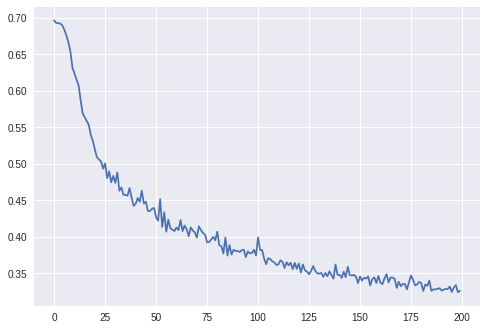

In [18]:
cost = np.array(costs)
plt.plot(cost)

In [0]:
# validation_costs

In [0]:
# costs = np.array(costs)
# costs = costs.reshape(len(costs),1)
# train_accuracy = np.array(train_accuracy)
# train_accuracy = train_accuracy.reshape(len(train_accuracy),1)
# validation_accuracy = np.array(validation_accuracy)
# validation_accuracy = validation_accuracy.reshape(len(validation_accuracy),1)
# steps = []
# for i in range(0,costs.shape[0],1):
#     steps.append(i)
# steps = np.array(steps).reshape(costs.shape[0],1)  
# print("Train Accuracy : "+str(train_accuracy[len(train_accuracy)-1,0]))
# print("Test Accuracy : "+str(validation_accuracy[len(validation_accuracy)-1,0]))
# plt.plot(steps,costs)
# plt.ylabel('Cost')
# plt.xlabel('Iterations (X 100)')
# plt.title("Cost vs No of Iterations(X 100)")
# plt.show()
# #plt.plot(steps, train_acc)
# #plt.ylabel('Train Accuracy')
# #plt.xlabel('Iterations (X 100)')
# #plt.title("Train Accuracy vs Iterations(X 100)")
# #plt.show()
# print(costs)
# print(validation_accuracy)
# plt.plot(steps,validation_accuracy)
# plt.ylabel('Test Accuracy')
# plt.xlabel('Iterations (X 100)')
# plt.title("Test Accuracy vs Iteration(X 100)")
# plt.show()

In [0]:
def model(learning_rate,batch_size,num_epochs):

    with tf.device('/device:GPU:2'):
      batch_size= 15
      num_epochs= 200

      tf.reset_default_graph()
      ops.reset_default_graph()
      tf.set_random_seed(1)

      num_minibatches = math.ceil(X_train.shape[0]/batch_size)

  #     initializing variables
      X,y = get_placeholders()
      parameters = initialize_variables()

  #     forward pass
      y_hat = forward_pass(X,parameters)
      cost = compute_cost(y_hat,y)
      accuracy = check_accuracy(y_hat,y)

  #     optimizer definiton
      optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(cost)

      costs = []
      train_accuracy = []
      validation_accuracy = []
      validation_costs = []

      seed = 0

      start_time = time.time()

      best_val_loss = float("inf")
      patience = 0
      early_stopping = None

      feed_dict_validate={X:X_test,y:y_test}

#     defining session as sess and initializing variables
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            cost_temp = 0.0
            accuracy_train_temp = 0.0
            accuracy_validation_temp = 0.0
            val_cost_temp = 0.0

#             loading the training data in minibatches
            minibatches = sample_minibatches(X_train,y_train,batch_size=batch_size,seed=seed)

            seed = seed + 1
            count=0       

#             taking minibatch and then computing accuracy and cost for each epoch
            for minibatch in minibatches:

                (minibatch_X,minibatch_Y) = minibatch

                feed_dict_train={X:minibatch_X,y:minibatch_Y}

                _ , cur_cost = sess.run([optimizer,cost],feed_dict=feed_dict_train)
                train_accuracy = sess.run([accuracy],feed_dict=feed_dict_train)

                validation_loss = sess.run([cost],feed_dict=feed_dict_validate)
                validation_accuracy = sess.run([accuracy], feed_dict=feed_dict_validate)

                if early_stopping:    
                    if validation_loss < best_val_loss:
                        best_val_loss = validation_loss
                        patience = 0
                    else:
                        patience += 1

                if patience == early_stopping:
                    break

                cost_temp = ((count*cost_temp) + cur_cost)/(count+1)
                accuracy_train_temp = ((count*accuracy_train_temp)+train_accuracy[0])/(count+1)

                val_cost_temp = ((count*val_cost_temp) + validation_loss[0])/(count+1)
                accuracy_validation_temp = ((count*accuracy_validation_temp)+validation_accuracy[0])/(count+1)

                count+=1

            print("EPOCH : "+str(epoch))
            print("Train loss: ", str(cost_temp))
            print("Validation loss: ", str(val_cost_temp))
            print("Train Accuracy : " + str(accuracy_train_temp))
            print("Validation Accuracy : " + str(accuracy_validation_temp))
            print("--------------------------------------------------------")
            
            costs.append(cost_temp)
            train_accuracy.append(accuracy_train_temp)
            validation_costs.append(val_cost_temp)
            validation_accuracy.append(accuracy_validation_temp)
            
            
            if patience == early_stopping:
                break

    return costs,parameters,train_accuracy,validation_costs,validation_accuracy

In [22]:
costs,parameters,train_accuracy,validation_costs,validation_accuracy = model(learning_rate=0.0001,batch_size =15,num_epochs = 200)

EPOCH : 0
Train loss:  0.699081438779831
Validation loss:  0.6986428499221802
Train Accuracy : 0.4333333417773247
Validation Accuracy : 0.44000000655651095
--------------------------------------------------------
EPOCH : 1
Train loss:  0.697049206495285
Validation loss:  0.6976477444171906
Train Accuracy : 0.43333333879709246
Validation Accuracy : 0.44000000357627866
--------------------------------------------------------
EPOCH : 2
Train loss:  0.6977729201316833
Validation loss:  0.6972415208816528
Train Accuracy : 0.3933333419263363
Validation Accuracy : 0.43000000417232515
--------------------------------------------------------
EPOCH : 3
Train loss:  0.697777247428894
Validation loss:  0.6945889532566071
Train Accuracy : 0.3266666762530804
Validation Accuracy : 0.3700000077486038
--------------------------------------------------------
EPOCH : 4
Train loss:  0.6998770713806153
Validation loss:  0.6948708474636078
Train Accuracy : 0.37333334013819697
Validation Accuracy : 0.4700000

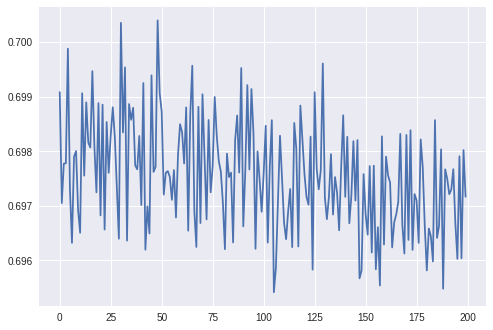

In [23]:
cost = np.array(costs)
plt.plot(cost)

In [0]:
def model(learning_rate,batch_size,num_epochs):

    with tf.device('/device:GPU:2'):
      batch_size= 15
      num_epochs= 200

      tf.reset_default_graph()
      ops.reset_default_graph()
      tf.set_random_seed(1)

      num_minibatches = math.ceil(X_train.shape[0]/batch_size)

  #     initializing variables
      X,y = get_placeholders()
      parameters = initialize_variables()

  #     forward pass
      y_hat = forward_pass(X,parameters)
      cost = compute_cost(y_hat,y)
      accuracy = check_accuracy(y_hat,y)

  #     optimizer definiton
      optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(cost)

      costs = []
      train_accuracy = []
      validation_accuracy = []
      validation_costs = []

      seed = 0

      start_time = time.time()

      best_val_loss = float("inf")
      patience = 0
      early_stopping = None

      feed_dict_validate={X:X_test,y:y_test}

#     defining session as sess and initializing variables
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            cost_temp = 0.0
            accuracy_train_temp = 0.0
            accuracy_validation_temp = 0.0
            val_cost_temp = 0.0

#             loading the training data in minibatches
            minibatches = sample_minibatches(X_train,y_train,batch_size=batch_size,seed=seed)

            seed = seed + 1
            count=0       

#             taking minibatch and then computing accuracy and cost for each epoch
            for minibatch in minibatches:

                (minibatch_X,minibatch_Y) = minibatch

                feed_dict_train={X:minibatch_X,y:minibatch_Y}

                _ , cur_cost = sess.run([optimizer,cost],feed_dict=feed_dict_train)
                train_accuracy = sess.run([accuracy],feed_dict=feed_dict_train)

                validation_loss = sess.run([cost],feed_dict=feed_dict_validate)
                validation_accuracy = sess.run([accuracy], feed_dict=feed_dict_validate)

                if early_stopping:    
                    if validation_loss < best_val_loss:
                        best_val_loss = validation_loss
                        patience = 0
                    else:
                        patience += 1

                if patience == early_stopping:
                    break

                cost_temp = ((count*cost_temp) + cur_cost)/(count+1)
                accuracy_train_temp = ((count*accuracy_train_temp)+train_accuracy[0])/(count+1)

                val_cost_temp = ((count*val_cost_temp) + validation_loss[0])/(count+1)
                accuracy_validation_temp = ((count*accuracy_validation_temp)+validation_accuracy[0])/(count+1)

                count+=1

            print("EPOCH : "+str(epoch))
            print("Train loss: ", str(cost_temp))
            print("Validation loss: ", str(val_cost_temp))
            print("Train Accuracy : " + str(accuracy_train_temp))
            print("Validation Accuracy : " + str(accuracy_validation_temp))
            print("--------------------------------------------------------")
            
            costs.append(cost_temp)
            train_accuracy.append(accuracy_train_temp)
            validation_costs.append(val_cost_temp)
            validation_accuracy.append(accuracy_validation_temp)
            
            
            if patience == early_stopping:
                break

    return costs,parameters,train_accuracy,validation_costs,validation_accuracy

In [34]:
costs,parameters,train_accuracy,validation_costs,validation_accuracy = model(learning_rate=0.0001,batch_size =15,num_epochs = 200)

EPOCH : 0
Train loss:  0.6989909052848816
Validation loss:  0.6971698343753815
Train Accuracy : 0.42666667625308036
Validation Accuracy : 0.45000000596046447
--------------------------------------------------------
EPOCH : 1
Train loss:  0.6964797079563141
Validation loss:  0.696183305978775
Train Accuracy : 0.420000009983778
Validation Accuracy : 0.45000000298023224
--------------------------------------------------------
EPOCH : 2
Train loss:  0.6966890633106232
Validation loss:  0.6953575074672699
Train Accuracy : 0.37333334535360335
Validation Accuracy : 0.45000000596046447
--------------------------------------------------------
EPOCH : 3
Train loss:  0.6965332806110383
Validation loss:  0.6935687363147736
Train Accuracy : 0.35333334356546403
Validation Accuracy : 0.4000000089406967
--------------------------------------------------------
EPOCH : 4
Train loss:  0.6975485920906067
Validation loss:  0.6934206783771515
Train Accuracy : 0.42000000849366187
Validation Accuracy : 0.4600

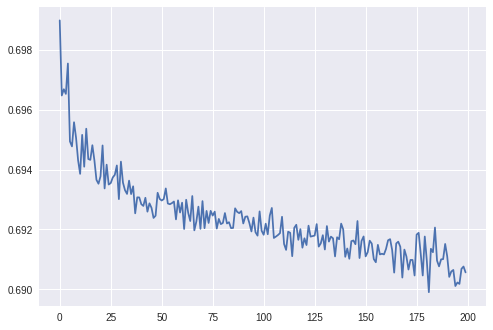

In [35]:
cost = np.array(costs)
plt.plot(cost)

In [0]:
# costs = np.array(costs)
# costs = costs.reshape(len(costs),1)
# train_accuracy = np.array(train_accuracy)
# train_accuracy = train_accuracy.reshape(len(train_accuracy),1)
# validation_accuracy = np.array(validation_accuracy)
# validation_accuracy = validation_accuracy.reshape(len(validation_accuracy),1)
# steps = []
# for i in range(0,costs.shape[0],1):
#     steps.append(i)
# steps = np.array(steps).reshape(costs.shape[0],1)  
# print("Train Accuracy : "+str(train_accuracy[len(train_accuracy)-1,0]))
# print("Test Accuracy : "+str(validation_accuracy[len(validation_accuracy)-1,0]))
# plt.plot(steps,costs)
# plt.ylabel('Cost')
# plt.xlabel('Iterations (X 100)')
# plt.title("Cost vs No of Iterations(X 100)")
# plt.show()
# #plt.plot(steps, train_acc)
# #plt.ylabel('Train Accuracy')
# #plt.xlabel('Iterations (X 100)')
# #plt.title("Train Accuracy vs Iterations(X 100)")
# #plt.show()
# print(costs)
# print(validation_accuracy)
# plt.plot(steps,validation_accuracy)
# plt.ylabel('Test Accuracy')
# plt.xlabel('Iterations (X 100)')
# plt.title("Test Accuracy vs Iteration(X 100)")
# plt.show()

EPOCH : 0
Train loss:  0.697402048110962
Validation loss:  0.694051718711853
Train Accuracy : 0.44000001177191733
Validation Accuracy : 0.46000000834465027
--------------------------------------------------------
EPOCH : 1
Train loss:  0.6940008044242859
Validation loss:  0.6932014703750611
Train Accuracy : 0.4733333483338356
Validation Accuracy : 0.4400000087916851
--------------------------------------------------------
EPOCH : 2
Train loss:  0.6930988073348999
Validation loss:  0.6931488513946533
Train Accuracy : 0.44000001102685926
Validation Accuracy : 0.5000000029802323
--------------------------------------------------------
EPOCH : 3
Train loss:  0.6932746171951294
Validation loss:  0.6931796431541443
Train Accuracy : 0.5133333459496499
Validation Accuracy : 0.4800000056624413
--------------------------------------------------------
EPOCH : 4
Train loss:  0.6930954217910766
Validation loss:  0.6928984820842743
Train Accuracy : 0.5533333465456962
Validation Accuracy : 0.49000000

KeyboardInterrupt: ignored

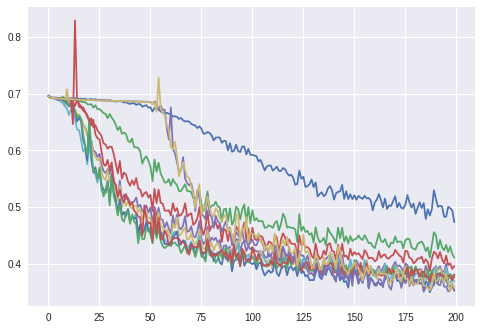

In [39]:
for i in range(1,30):
  costs,parameters,train_accuracy,validation_costs,validation_accuracy = model(learning_rate=i*0.001,batch_size =15,num_epochs = 100)
  cost = np.array(costs)
  plt.plot(cost)

In [0]:
#Implementing custom activation function

In [0]:
def activation(x):
  return x*x*tf.math.sigmoid(x)

In [0]:
def forward_pass(X_batch,parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    W4 = parameters["W4"]
    flatten=parameters["flatten"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    b3 = parameters["b3"]
    b4 = parameters["b4"]
    b_flatten=parameters["b_flatten"]
    keep_prob1 = parameters["keep_prob1"]
    keep_prob2 = parameters["keep_prob2"]
    keep_prob3 = parameters["keep_prob3"]
    keep_prob4 = parameters["keep_prob4"]
    
#     X_batch = X_batch.astype(np.float32)
    Z1 = tf.nn.conv2d(X_batch,W1,strides = [1,1,1,1],padding = 'SAME') + b1
    A1 = activation(Z1)
    A1= tf.nn.dropout(A1, keep_prob1)

    P1 = tf.nn.max_pool(A1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1,W2,strides = [1,1,1,1],padding = 'SAME') + b2
    A2 = activation(Z2)
    A2=tf.nn.dropout(A2, keep_prob2)

    P2 = tf.nn.max_pool(A2,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'SAME')
    
    P2_flat_ = tf.nn.conv2d(P2,flatten,strides = [1,1,1,1],padding='SAME')+b_flatten
    P2_flat = tf.nn.dropout((tf.nn.relu(P2_flat_)),keep_prob3)
    P2_flat = tf.layers.flatten(P2_flat)
    
    Z3= tf.matmul(P2_flat,W3) + b3
    A3 = activation(Z3)
    A3= tf.nn.dropout(A3, keep_prob4)
    
    Z4 = tf.matmul(A3,W4) + b4
    y_hat = tf.nn.sigmoid(Z4)
    
    return y_hat

In [0]:
def model(learning_rate,batch_size,num_epochs):

    with tf.device('/device:GPU:2'):
      batch_size= 15
      num_epochs= 200

      tf.reset_default_graph()
      ops.reset_default_graph()
      tf.set_random_seed(1)

      num_minibatches = math.ceil(X_train.shape[0]/batch_size)

  #     initializing variables
      X,y = get_placeholders()
      parameters = initialize_variables()

  #     forward pass
      y_hat = forward_pass(X,parameters)
      cost = compute_cost(y_hat,y)
      accuracy = check_accuracy(y_hat,y)

  #     optimizer definiton
      optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

      costs = []
      train_accuracy = []
      validation_accuracy = []
      validation_costs = []

      seed = 0

      start_time = time.time()

      best_val_loss = float("inf")
      patience = 0
      early_stopping = None

      feed_dict_validate={X:X_test,y:y_test}

#     defining session as sess and initializing variables
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            cost_temp = 0.0
            accuracy_train_temp = 0.0
            accuracy_validation_temp = 0.0
            val_cost_temp = 0.0

#             loading the training data in minibatches
            minibatches = sample_minibatches(X_train,y_train,batch_size=batch_size,seed=seed)

            seed = seed + 1
            count=0       

#             taking minibatch and then computing accuracy and cost for each epoch
            for minibatch in minibatches:

                (minibatch_X,minibatch_Y) = minibatch

                feed_dict_train={X:minibatch_X,y:minibatch_Y}

                _ , cur_cost = sess.run([optimizer,cost],feed_dict=feed_dict_train)
                train_accuracy = sess.run([accuracy],feed_dict=feed_dict_train)

                validation_loss = sess.run([cost],feed_dict=feed_dict_validate)
                validation_accuracy = sess.run([accuracy], feed_dict=feed_dict_validate)

                if early_stopping:    
                    if validation_loss < best_val_loss:
                        best_val_loss = validation_loss
                        patience = 0
                    else:
                        patience += 1

                if patience == early_stopping:
                    break

                cost_temp = ((count*cost_temp) + cur_cost)/(count+1)
                accuracy_train_temp = ((count*accuracy_train_temp)+train_accuracy[0])/(count+1)

                val_cost_temp = ((count*val_cost_temp) + validation_loss[0])/(count+1)
                accuracy_validation_temp = ((count*accuracy_validation_temp)+validation_accuracy[0])/(count+1)

                count+=1

            print("EPOCH : "+str(epoch))
            print("Train loss: ", str(cost_temp))
            print("Validation loss: ", str(val_cost_temp))
            print("Train Accuracy : " + str(accuracy_train_temp))
            print("Validation Accuracy : " + str(accuracy_validation_temp))
            print("--------------------------------------------------------")
            
            costs.append(cost_temp)
            train_accuracy.append(accuracy_train_temp)
            validation_costs.append(val_cost_temp)
            validation_accuracy.append(accuracy_validation_temp)
            
            
            if patience == early_stopping:
                break

    return costs,parameters,train_accuracy,validation_costs,validation_accuracy

In [44]:
costs,parameters,train_accuracy,validation_costs,validation_accuracy = model(learning_rate=0.0001,batch_size =15,num_epochs = 200)

EPOCH : 0
Train loss:  0.6931917369365692
Validation loss:  0.6931298494338989
Train Accuracy : 0.5333333343267441
Validation Accuracy : 0.5099999994039536
--------------------------------------------------------
EPOCH : 1
Train loss:  0.6930687129497528
Validation loss:  0.6931197464466095
Train Accuracy : 0.6933333367109299
Validation Accuracy : 0.5200000047683716
--------------------------------------------------------
EPOCH : 2
Train loss:  0.6922673583030701
Validation loss:  0.693093329668045
Train Accuracy : 0.7466666728258133
Validation Accuracy : 0.5900000035762787
--------------------------------------------------------
EPOCH : 3
Train loss:  0.6863457977771759
Validation loss:  0.6906558454036713
Train Accuracy : 0.626666682958603
Validation Accuracy : 0.6600000023841858
--------------------------------------------------------
EPOCH : 4
Train loss:  0.6723050236701965
Validation loss:  0.6825676798820496
Train Accuracy : 0.633333346247673
Validation Accuracy : 0.620000010728

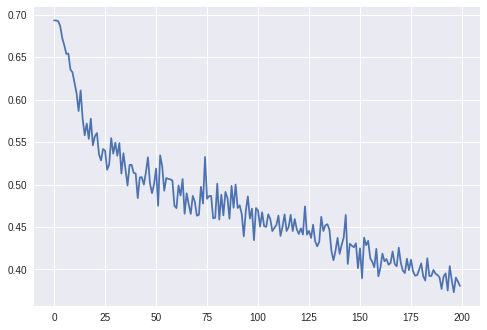

In [45]:
cost = np.array(costs)
plt.plot(cost)